# CODEX

Creating the CODEX AnnDatas from John's CSV. 

Some simple spatial visuazlistion of celltypes and analysis of cell type proproptions

In [1]:
from tidyverse.dummy import *
import scanpy as sc
import pathlib
from sctools.ottools import calc_patient_matrix_cost_matrix_on_the_fly, display_distance_matrix, calc_patient_matrix, yield_pairs_compute_cost
from sctools.transforms import split_adata
import sys
sys.path.append('/home/mstrasse/CRUK-code/')
from crukiopy_release.codex import load_sample, iterate_codex_adatas, INV_coarse_CT_dict, INV_coarse_CT_dict2, matt_diagnosis_dict, invert_dict

Importing tidyverse


# Creating the AnnDatas
John's csv stored in GCS
```
gsutil -m cp gs://mstrasse_tmp_data/22_01_CellAtlas_community_clustered.csv.gz .
```

In [2]:
# df = pd.read_csv('/home/michi/22_01_CellAtlas_community_clustered.csv.gz')
df = pd.read_csv('/home/mstrasse/TB4/22_01_CellAtlas_community_clustered.csv.gz')

In [3]:
df['sample_diagnosis'] = df['unique_region'] + '_' + df['Path_report']

In [4]:
genes = ['CHGA', 'MMP9', 'CD36', 'CK7', 'PDL1', 'Bcatenin',
       'Vimentin', 'FoxP3', 'CD56', 'CD31', 'pH2AX', 'CD90', 'CD15', 'PD1',
       'aSMA', 'CD25', 'Ki67', 'Cytokeratin', 'CD20', 'CD4', 'CD11c',
       'AnnexA1', 'Nestin', 'p53', 'CD73', 'EGFR', 'MUC5AC', 'HLADR', 'COX2',
       'BCL2', 'p63', 'CD3', 'MUC2', 'CD8', 'CD45', 'PGA3', 'CD57', 'CD68',
       'aDef5', 'CD34', 'Podoplanin', 'CD38', 'CD11b', 'CD163', 'MUC1',
       'CD138', 'Arginase1', 'PP', 'CD79a', 'MUC6', 'CD206', 'CollIV']
metadata = ['region',
       'sample', 'region_num', 'Christian_annotations',
       'unique_region', 'Accession_number', 'Block_ID', 'Sample_type',
       'Path_report', 'neigh_name', 'neigh_sub', 'community',
       'community common', 'Cell Type', 'Core Type', 'sample_diagnosis']
coords = ['x','y']

## some info about the fields:
- Sample_type: biopsy vs reection
- sample: E08, E11...
- unique_region: concat of sample + region
- Accession_number: seems to be something sample/patient specific
- Block_ID: no idea, spans multiple patients

multiple regions per sample

In [7]:
pd.crosstab(df.unique_region, df['Path_report'])

Path_report    Metaplasia  Metaplasia + Dysplasia + Tumor  Metaplasia + Tumor  \
unique_region                                                                   
E08_reg001              0                               0                   0   
E08_reg002              0                               0                   0   
E08_reg003              0                               0                   0   
E08_reg004              0                               0                   0   
E08_reg005              0                               0                   0   
E08_reg006          15214                               0                   0   
E08_reg007           9395                               0                   0   
E11_reg001              0                               0                   0   
E11_reg002              0                               0                   0   
E11_reg003              0                               0               10159   
E11_reg004           9478                               0                   0   
E11_reg005              0                               0                   0   
E11_reg006              0                               0                   0   
E12_reg001              0                           31906                   0   
E12_reg002              0                           32934                   0   
E12_reg003              0                           40266                   0   
E12_reg004              0                           21458                   0   
E12_reg005              0                           21019                   0   
E17_reg001              0                               0                   0   
E17_reg002              0                               0                   0   
E17_reg003              0                               0                   0   
E17_reg004              0                               0                   0   
E17_reg005              0                               0                   0   
E17_reg006           9320                               0                   0   
E18_reg001          55154                               0                   0   
E18_reg002          42466                               0                   0   
E18_reg003              0                               0                   0   
E18_reg004              0                               0                   0   
E19_reg001              0                               0                   0   
E19_reg002              0                               0                   0   
E19_reg003              0                               0                   0   
E19_reg004              0                               0                   0   

Path_report    Metaplasia; Dysplasia?  Normal esophagus  \
unique_region                                             
E08_reg001                          0                 0   
E08_reg002                          0              5949   
E08_reg003                          0              7376   
E08_reg004                          0                 0   
E08_reg005                          0                 0   
E08_reg006                          0                 0   
E08_reg007                          0                 0   
E11_reg001                          0                 0   
E11_reg002                          0                 0   
E11_reg003                          0                 0   
E11_reg004                          0                 0   
E11_reg005                          0                 0   
E11_reg006                          0                 0   
E12_reg001                          0                 0   
E12_reg002                          0                 0   
E12_reg003                          0                 0   
E12_reg004                          0                 0   
E12_reg005                          0                 0   
E17_reg001                          0              7134   
E17_re

## turn into adata

In [5]:
X = df[genes].values.astype('float32')
X = X - X.min() + 1e-16
obs = df[metadata]
var = pd.DataFrame(index= genes)

adata = sc.AnnData(X, obs=obs, var=var)
adata.obsm['X_spatial'] = df[coords].values

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.


<AxesSubplot:>

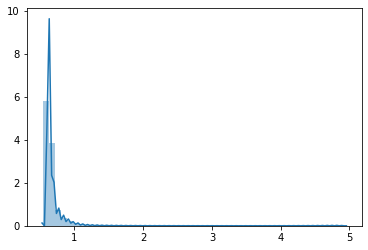

In [6]:
sns.distplot(np.log(0.00001+adata.X[:,0]))

In [13]:
!mkdir /home/mstrasse/TB4/CODEX_adata

## run processing on each sample separately, save to disk as adata

In [18]:
for g, a_tmp in split_adata(adata, 'unique_region'):
    sc.pp.log1p(a_tmp)
    sc.pp.scale(a_tmp)
    sc.pp.pca(a_tmp)
    sc.pp.neighbors(a_tmp)
    sc.tl.umap(a_tmp)
    sc.tl.leiden(a_tmp)
    sc.tl.rank_genes_groups(a_tmp, groupby='leiden')
    a_tmp.obs['UMAP1']= a_tmp.obsm['X_umap'][:,0]
    a_tmp.obs['UMAP2']= a_tmp.obsm['X_umap'][:,1]
    a_tmp.write_h5ad(f'/home/mstrasse/TB4/CODEX_adata/{g}.h5ad')

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'sample' as categorical
... storing 'region_num' as categorical
... storing 'Christian_annotations' as categorical
... storing 'unique_region' as categorical
... storing 'Accession_number' as categorical
... storing 'Block_ID' as categorical
... storing 'Sample_type' as categorical
... storing 'Path_report' as categorical
... storing 'neigh_name' as categorical
... storing 'neigh_sub' as categorical
... storing 'community' as categorical
... storing 'community common' as categorical
... storing 'Cell Type' as categorical
... storing 'Core Type' as categorical
... storing 's

Upload into google storage 

`gsutil -m CODEX_adata gs://mstrasse_tmp_data`

# Analysis

### Doing PCA/UMAP on ALL cells (across samples)

In [8]:
sc.pp.pca(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

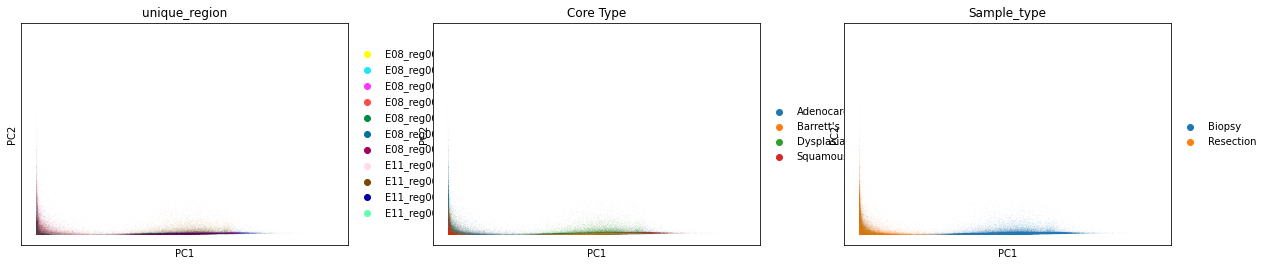

In [11]:
sc.pl.pca(adata, color=['unique_region', 'Core Type', 'Sample_type'])

In [ ]:
sc.pl.pca_variance_ratio(adata)

## a coarser mapping 
Aggregrate John's cell types a bit

In [2]:
import plotly.graph_objects as go

def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

In [3]:
dd = []
for ct in INV_coarse_CT_dict.keys():
    dd.append({'Cell type': ct, 'Coarse CT': INV_coarse_CT_dict[ct]+'_', 'value':1, 'Coarser CT': INV_coarse_CT_dict2[ct] +'__'})
dd = pd.DataFrame(dd)

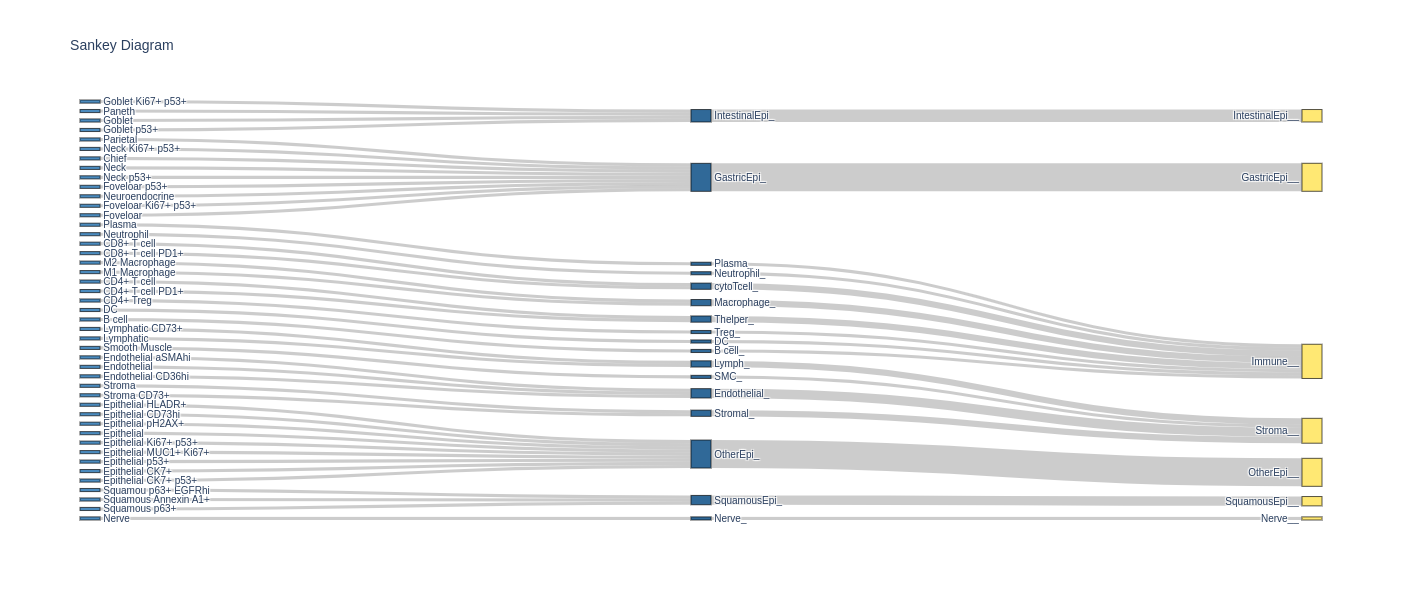

In [4]:
fig = genSankey(dd,cat_cols=['Cell type', 'Coarse CT', 'Coarser CT'], value_cols='value',title='Sankey Diagram')
fig = go.Figure(fig)
fig.update_layout(font_size=10, height=600, width=600)

Visualize the cell types in spatial coordinates

... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


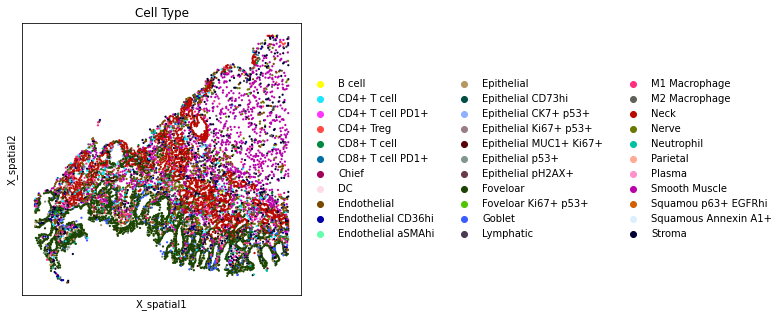

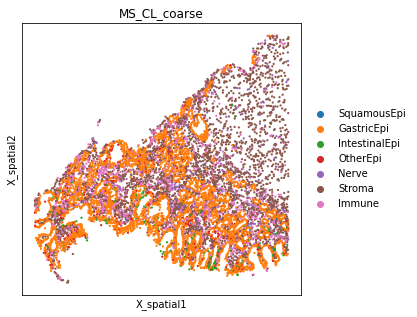

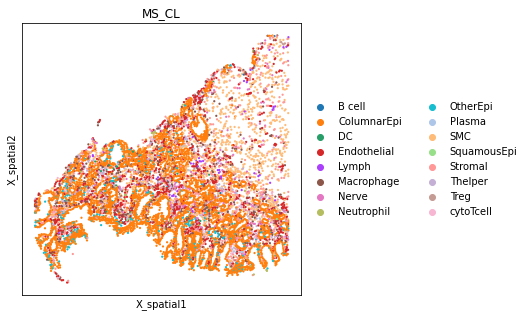

In [10]:
figsize = (5,5)
adata = load_sample('E17_reg002')
plt.figure(figsize=figsize)
sc.pl.embedding(adata, basis='X_spatial', color=['Cell Type'], ax=plt.gca(),size=20)
plt.figure(figsize=figsize)
sc.pl.embedding(adata, basis='X_spatial', color=['MS_CL_coarse'], ax=plt.gca(),size=20)
plt.figure(figsize=figsize)
sc.pl.embedding(adata, basis='X_spatial', color=['MS_CL'], ax=plt.gca(),size=20)

## Replicates
plotting all the samples from the same patient/diagnosis together, lets see how different

-----E08---M-------


... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


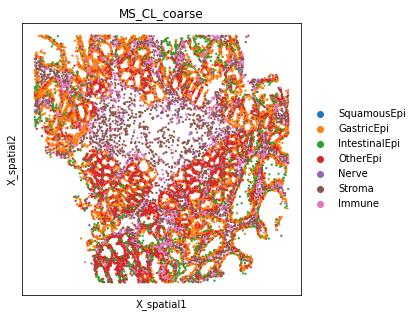

... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


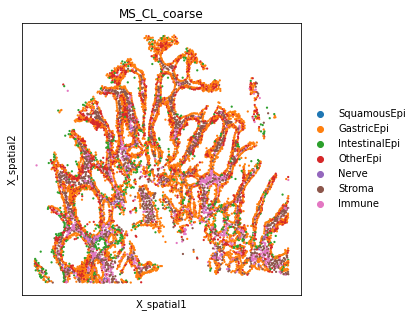

-----E08---NE-------


... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


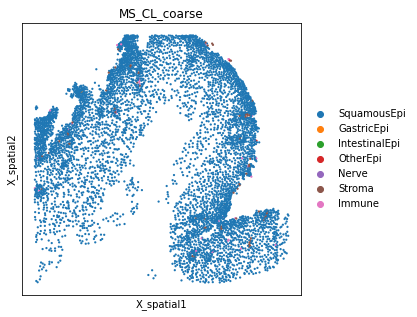

... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


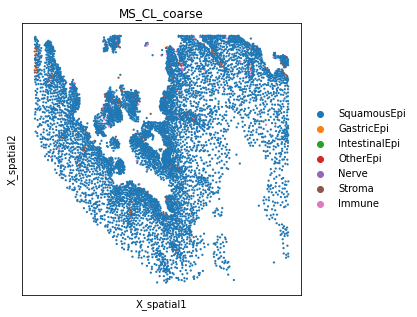

-----E08---T-------


... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


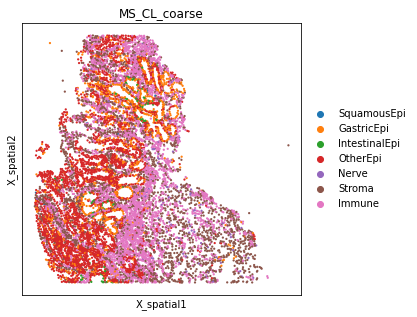

... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


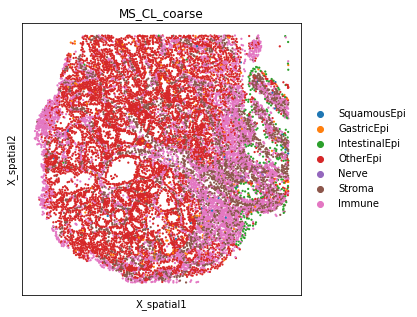

... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


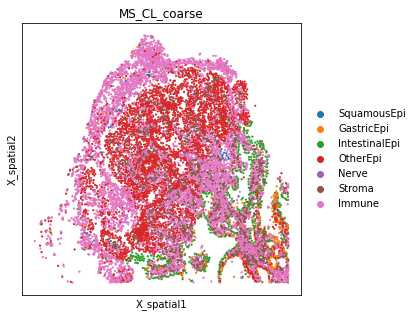

-----E11---?-------


... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


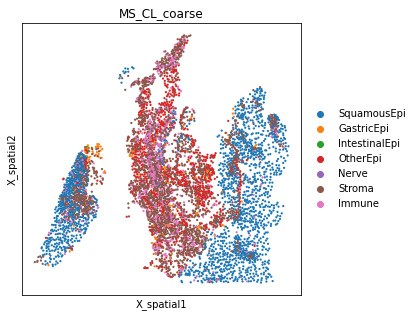

... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


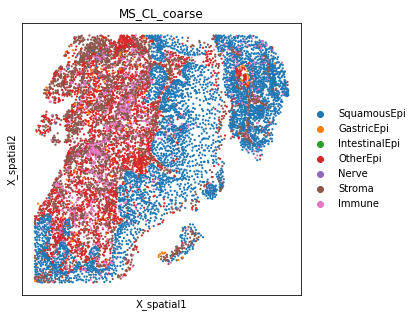

-----E11---T-------


... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


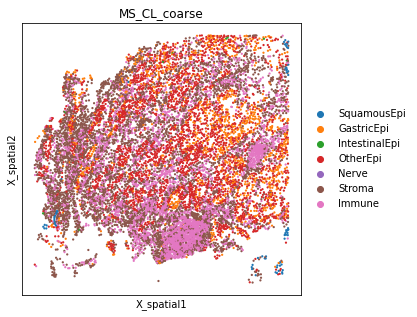

... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


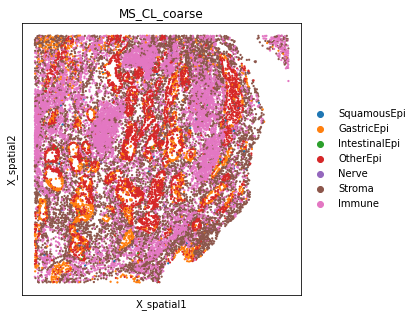

... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


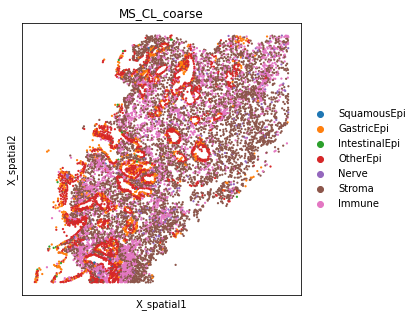

-----E12---NE/NS-------


... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


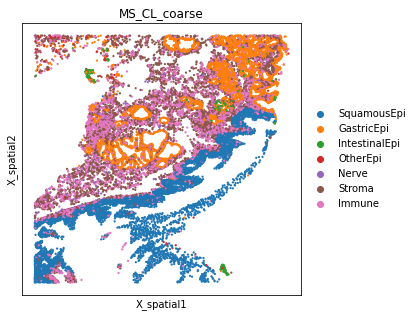

... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


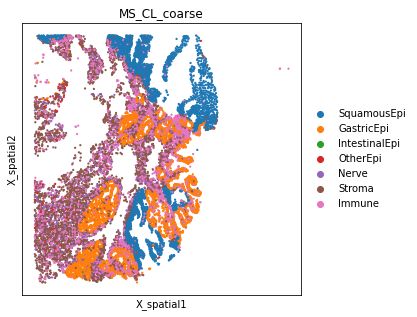

-----E17---M-------


... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


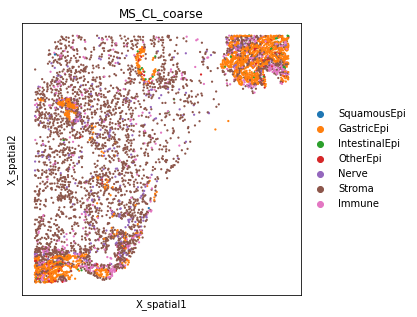

... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


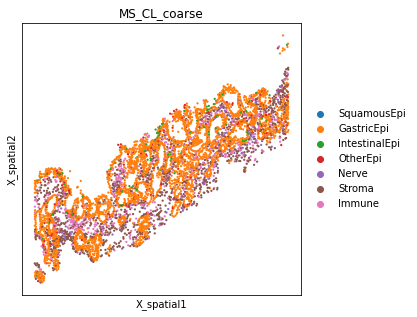

... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


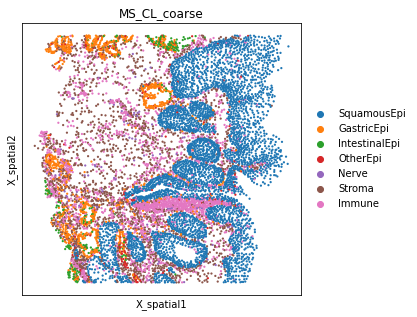

-----E18---T-------


... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


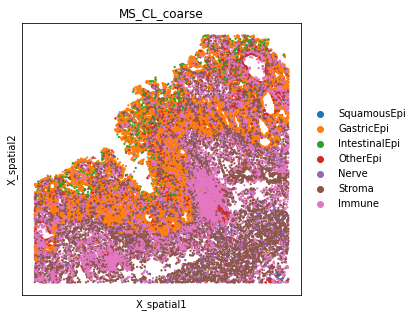

... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


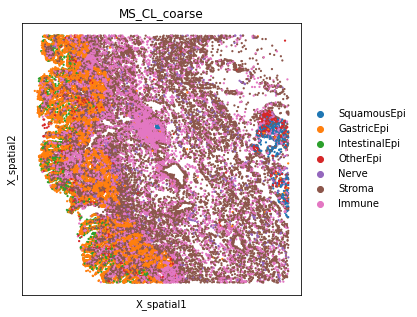

... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


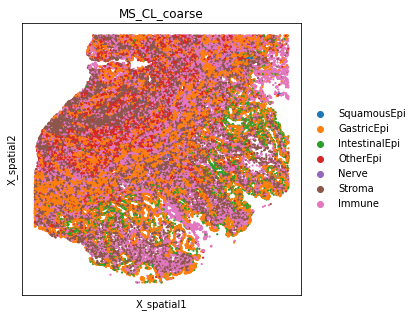

... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


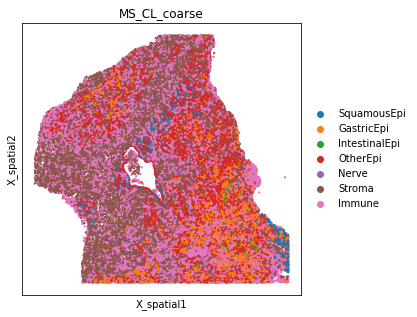

-----E19---T-------


... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


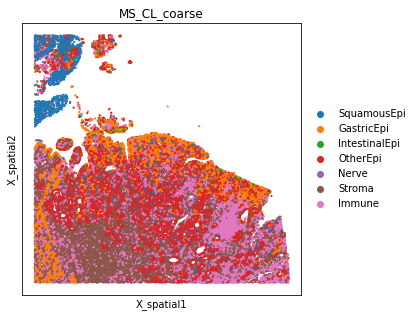

... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


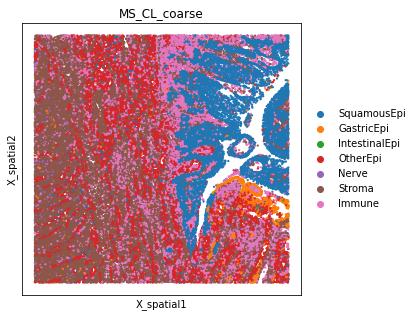

... storing 'samplename' as categorical
... storing 'MS_CL' as categorical


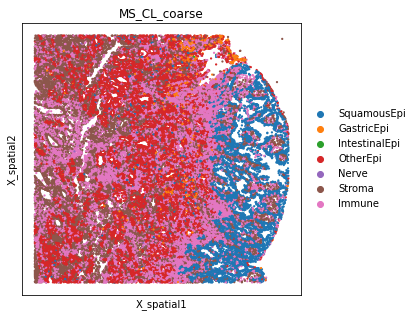

In [13]:
for (patient, di), df_group in matt_diagnosis_dict.groupby(['patient', 'rediagnosis']):
    samples = df_group.samplename.values
    if len(samples) == 1: continue
    
    print(f'-----{patient}---{di}-------')
    for s in samples:
        adata = load_sample(s)
        plt.figure(figsize=(5,5))
#         sc.pl.embedding(adata, basis='X_spatial', color=['Cell Type'], ax=plt.gca(),size=20)
#         sc.pl.embedding(adata, basis='X_spatial', color=['MS_CL'], ax=plt.gca(),size=20)   
        sc.pl.embedding(adata, basis='X_spatial', color=['MS_CL_coarse'], ax=plt.gca(),size=20)

## Visualize the composition of a single sample on multiple levels of granularity

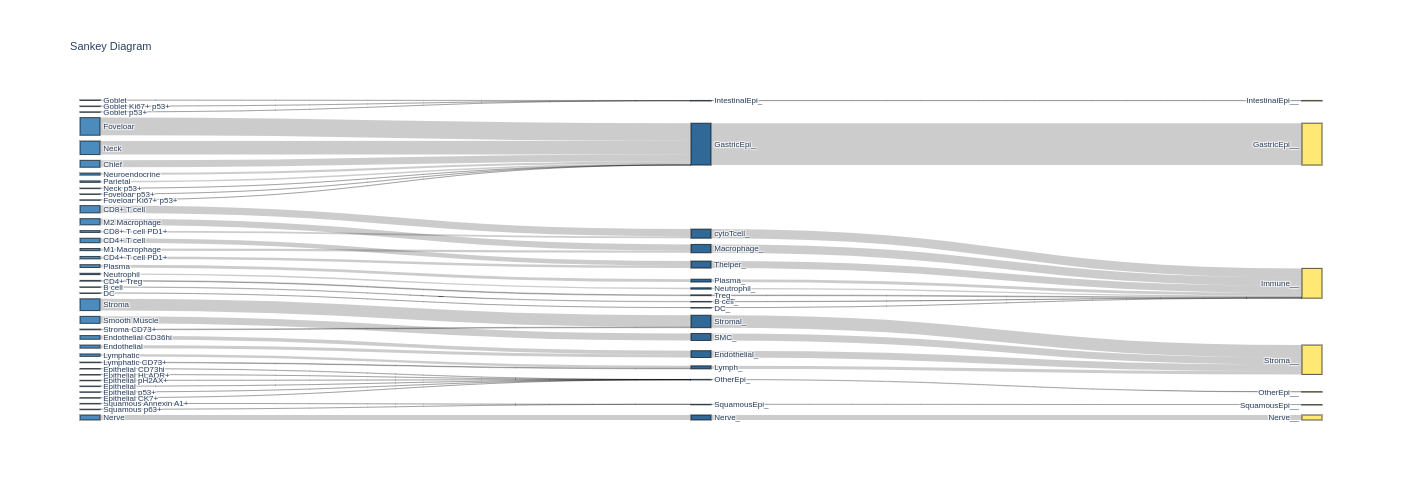

In [5]:
adata = load_sample('E12_reg003')
freqs = collections.defaultdict(lambda: 0, adata.obs['Cell Type'].value_counts().to_dict())
dd = []
for ct in INV_coarse_CT_dict.keys():
    dd.append({'Cell type': ct, 'Coarse CT': INV_coarse_CT_dict[ct]+'_', 'value': freqs[ct], 'Coarser CT': INV_coarse_CT_dict2[ct] +'__'})
dd = pd.DataFrame(dd)
fig = genSankey(dd,cat_cols=['Cell type', 'Coarse CT', 'Coarser CT'], value_cols='value',title='Sankey Diagram')
fig = go.Figure(fig)
fig.update_layout(font_size=8, height=500, width=500)

# Cell type proporitions
build a single scCODA object out of all codex samples

In [16]:
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
from sccoda.util import comp_ana as mod

In [13]:
# celltype_level = 'MS_CL'
# celltype_order =  ['SquamousEpi', 'GastricEpi','IntestinalEpi', 'OtherEpi', 'Stromal','SMC', 'Endothelial', 'Lymph', 'Nerve', 'B cell', 'Plasma','Thelper','Treg', 'cytoTcell', 'Neutrophil', 'DC','Macrophage']

celltype_level = 'MS_CL_coarse'
celltype_order =  ['SquamousEpi', 'GastricEpi','IntestinalEpi', 'OtherEpi', 'Stroma', 'Immune', 'Nerve']

df_celltypes = []
df_for_adata = []
for sname, adata in  iterate_codex_adatas():
    c = pd.DataFrame({'counts': adata.obs[celltype_level].value_counts()}).reset_index().rename({'index': 'celltype'}, axis=1)
    c['samplename'] = sname
    df_celltypes.append(c)

    # this one is wide
    d = pd.DataFrame(adata.obs[celltype_level].value_counts()).T
    d['samplename'] = sname
    df_for_adata.append(d)

df_celltypes = pd.concat(df_celltypes)
df_for_adata = pd.concat(df_for_adata).replace({np.nan: 0})

# adding matts diagnosis
df_for_adata = df_for_adata.merge(matt_diagnosis_dict, on='samplename', how='left').set_index('samplename')

32it [00:09,  3.40it/s]


In [17]:
# order the diagnosis
df_for_adata['diagnosis'] = pd.Categorical(df_for_adata.diagnosis, categories=['NE','M','T','NE/T','MD'])

rediag_order = ['NE','M','D', 'T','NS','NE/NS','?']
df_for_adata['rediagnosis'] = pd.Categorical(df_for_adata.rediagnosis, categories=rediag_order)

In [18]:
data_scanpy_1 = dat.from_pandas(df_for_adata, covariate_columns=['procedure','matt_diagnosis','rediagnosis','diagnosis','patient'])

In [19]:
diagnosis_ordered = rediag_order#  ['NE','M','D', 'T','NE/NS','?']#  ['NE', 'M','D','T', 'NS', 'NE/T', 'MD']
order = []
for d in diagnosis_ordered:
    order.extend(sorted(matt_diagnosis_dict.query('rediagnosis==@d').samplename))

Cell type proportions across samples

/home/mstrasse/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


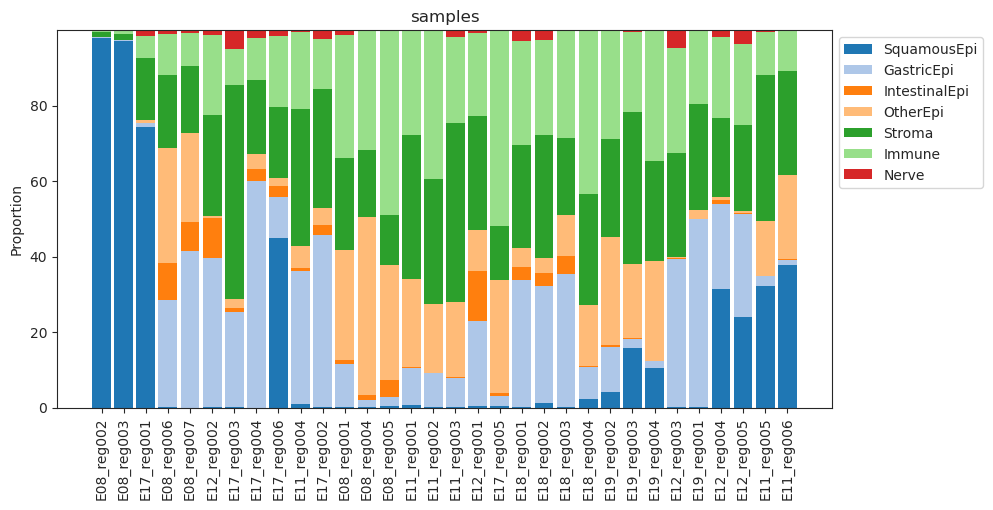

In [20]:
fig = viz.stacked_barplot(data_scanpy_1[:, celltype_order], feature_name="samples", figsize=(10,5),
                          level_order=order)
                          #cmap=cmap_subtypes)
plt.xticks(rotation=90);

CEll type proportions across Matt's diagnosis

<AxesSubplot:title={'center':'rediagnosis'}, ylabel='Proportion'>

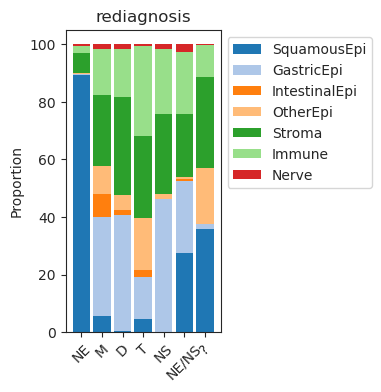

In [21]:
viz.stacked_barplot(data_scanpy_1[:, celltype_order], feature_name="rediagnosis",figsize=(2,4))

Biopsy only

<AxesSubplot:title={'center':'rediagnosis'}, ylabel='Proportion'>

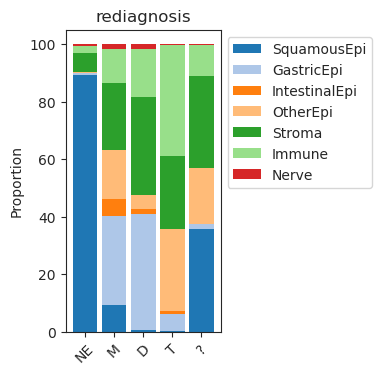

In [22]:
viz.stacked_barplot(data_scanpy_1[data_scanpy_1.obs['procedure']=="Biopsy", celltype_order], feature_name="rediagnosis",figsize=(2,4))

resection only

<AxesSubplot:title={'center':'rediagnosis'}, ylabel='Proportion'>

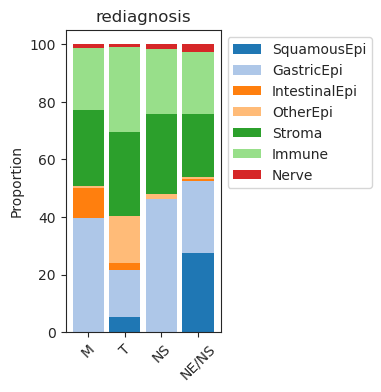

In [23]:
viz.stacked_barplot(data_scanpy_1[data_scanpy_1.obs['procedure']=="Resection", celltype_order], feature_name="rediagnosis",figsize=(2,4))

# another scCODA, but samples named/grouped by patient/diagnosis

In [24]:
df_for_adata.index = df_for_adata.patient + '_' + df_for_adata.rediagnosis.astype(str)
data_scanpy_1 = dat.from_pandas(df_for_adata, covariate_columns=['procedure','matt_diagnosis','rediagnosis','diagnosis','patient'])
data_scanpy_1.obs_names_make_unique()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


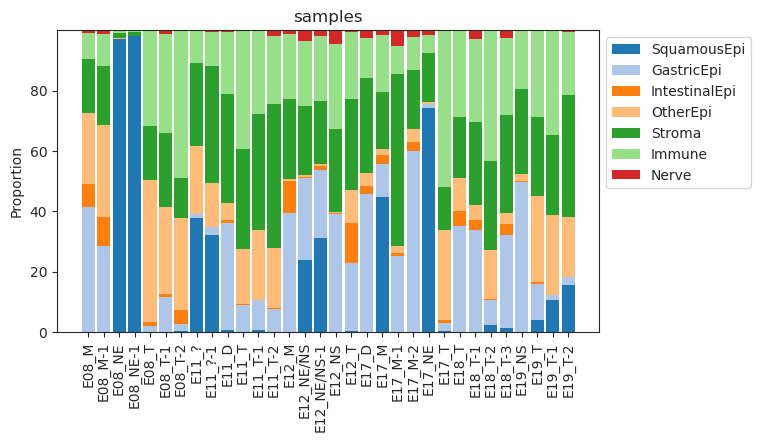

In [25]:
fig = viz.stacked_barplot(data_scanpy_1[:, celltype_order], feature_name="samples", figsize=(7,4),
                          level_order=sorted(data_scanpy_1.obs.index))
                          #cmap=cmap_subtypes)
plt.xticks(rotation=90);

# Correlation of CODEX proportions across samples
Pearson correlation CODEX against each other

<AxesSubplot:>

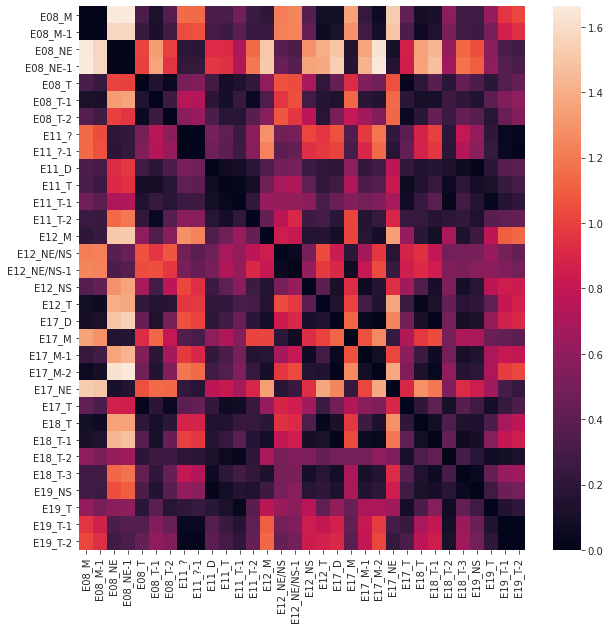

In [27]:
from scipy.spatial.distance import pdist, squareform
D = squareform(pdist(np.log10(1+data_scanpy_1.X), metric='correlation'))
D =pd.DataFrame(D, index=data_scanpy_1.obs.index, columns=data_scanpy_1.obs.index)

D = D.loc[sorted(data_scanpy_1.obs.index), sorted(data_scanpy_1.obs.index)]
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(D,xticklabels=True, yticklabels=True,)

same matrix, just clustered by rows and columns

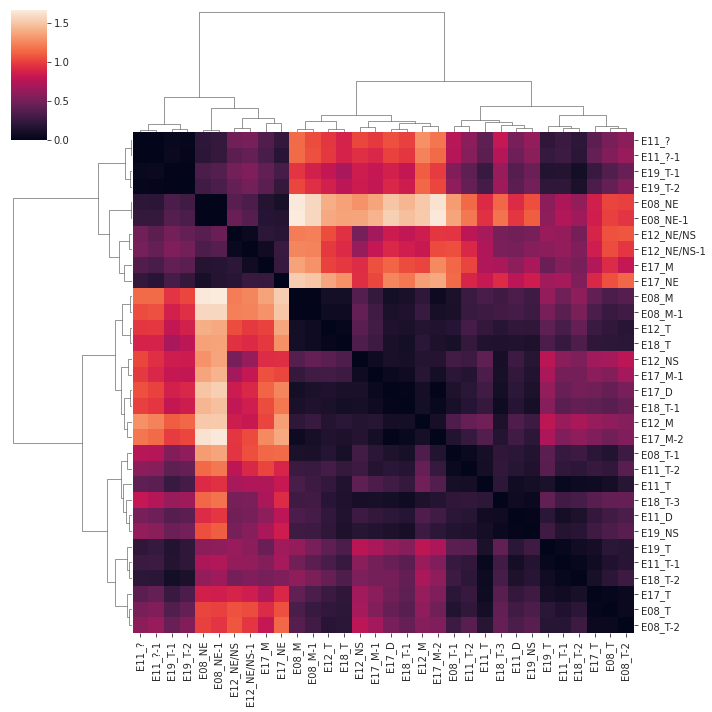

In [28]:
sns.clustermap(D,xticklabels=True, yticklabels=True, method='ward')

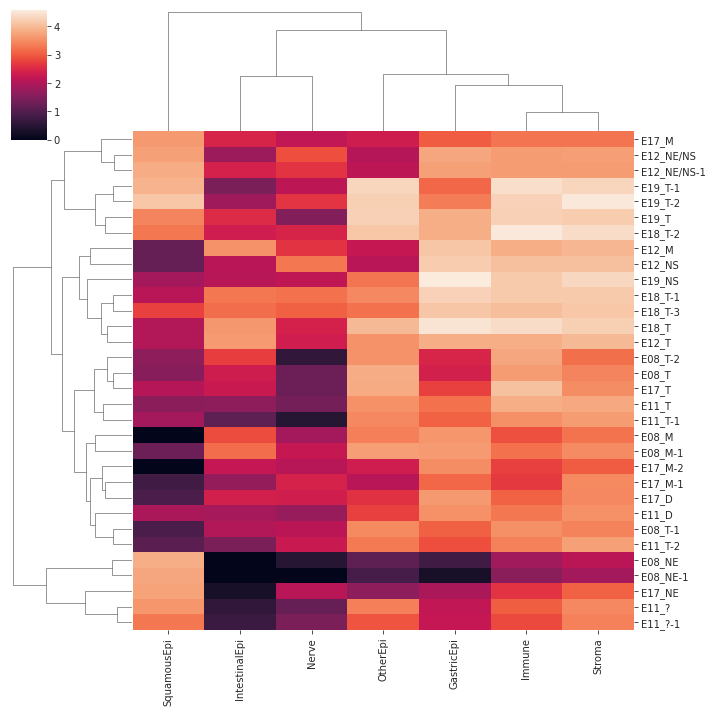

In [31]:
sns.clustermap(
    pd.DataFrame(np.log10(1+data_scanpy_1.X), index=data_scanpy_1.obs.index, columns=data_scanpy_1.var.index)
)